# Metody detekcji anomalii - laboratorium

* W pierwszej części laboratorium poznamy metody wyznaczania anomalii w danych (anomaly detection) oraz techniki badania czy nowe dane pochodzą ze znanego rozkładu (novelty/out-of-distribution (OOD) detection). 

* W drugiej części zastosujemy te techniki do reprezentacji generowanych przez głębokie sieci neuronowe. 



## Zadanie

Zadanie polega na zbadaniu różnych metod wykrywania anomalii - zilustrowanych w tej instrukcji (notebooku) do wykrywania anomalii w rzeczywistych zbiorach danych. 

Przykładową analizę dla danych rzeczywistych pokazujemy w notebooku **02_real_data.ipynb**.

Przebieg zadania:

**1. Wybieramy 3 zbiory danych** - z repozytorium -- link poniżej. Wybieramy zbiory o różnych charakterystykach (wymiarowość, liczba outlierów).

**2. Dla każdego zbioru** badamy skuteczność wykrywania anomalii za pomocą 3 metod - np. podanych w tej instrukcji, można też użyć inne metody (np. kNN lub inne metody z pakietu **pyod**). Staramy się dostroić parametry detektora anomalii tak żeby uzyskać wysoką skuteczność metody. 

**3. Opracowujemy raport z badań** - powinien zawierać miary skuteczności każdej badanej metody (ROC, AUC, FPR, TPR) oraz wpływ parametrów, które poddawaliśmy strojeniu. 


https://archive.ics.uci.edu/

https://web.archive.org/web/20240421011255/https://odds.cs.stonybrook.edu/


## Badamy metody wyznaczania *outlierness scores* na danych symulacyjnych

LOF \
odległość Mahalanobisa \
IRW depth \
isolation forest

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import default_rng
import time
import math


In [2]:
# generujemy dane MVN - dane znane (in-distribution, ID) oraz out-of-distribution (OOD) 

rng = default_rng()

d = 10
n = 500
mi = np.full(d, 0)
cov = np.identity(d)

X_train = rng.multivariate_normal(mi, cov, n)
X_test = rng.multivariate_normal(mi, cov, n)

# OOD
delta = 10
mi2 = np.full(d, delta/math.sqrt(d))
X_ood = rng.multivariate_normal(mi2, cov, n)


### LOF

-1.0614305747934059
-1.063780572583468
-2.9099073717870203


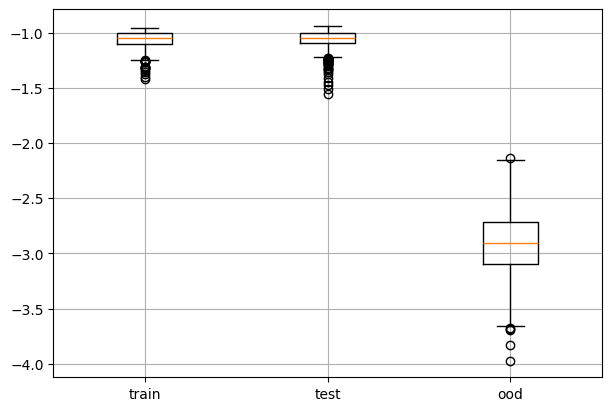

In [4]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(n_neighbors=35, novelty=True)

model.fit(X_train)

train_scores = model.score_samples(X_train)
test_scores = model.score_samples(X_test)
ood_scores = model.score_samples(X_ood)


if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], tick_labels=labels)
ax1.grid()

plt.show()

### Parametric model - assume MVN data
    
outlierness score - based on **Mahalanobis distance**


-10.586374518874832
-10.743261539510652
-114.05979103723922


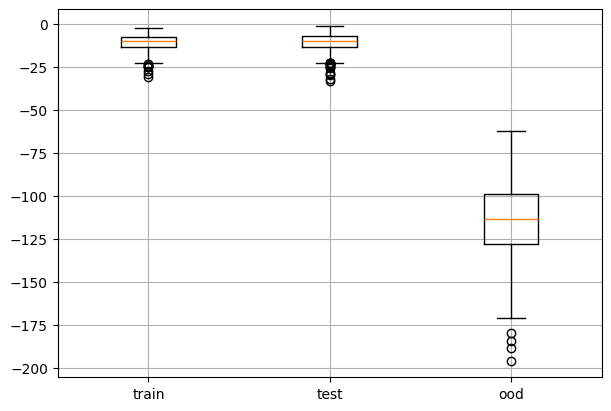

In [6]:
from sklearn.covariance import EllipticEnvelope

model = EllipticEnvelope(contamination=0.01, random_state=42)

model.fit(X_train)

train_scores = model.score_samples(X_train)
test_scores = model.score_samples(X_test)
ood_scores = model.score_samples(X_ood)


if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], tick_labels=labels)
ax1.grid()

plt.show()
## 

(500, 10)
(500, 10)
(1000, 10)


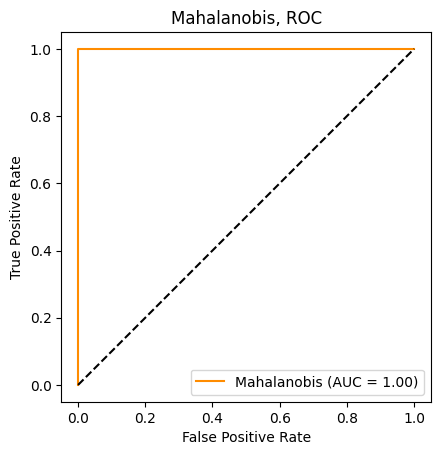

In [7]:
# ROC curve

print(X_test.shape)
print(X_ood.shape)
XX = np.concatenate((X_test,X_ood), axis=0)
print(XX.shape)

yy = [0]*X_test.shape[0] + [1]*X_ood.shape[0]      # 0 - ID, 1 - OOD


import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

yy_score = -model.decision_function(XX)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="Mahalanobis",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mahalanobis, ROC")
plt.legend()
plt.show()

### Isolation forest

-0.4408105355029403
-0.44150857897206275
-0.7079030424178387


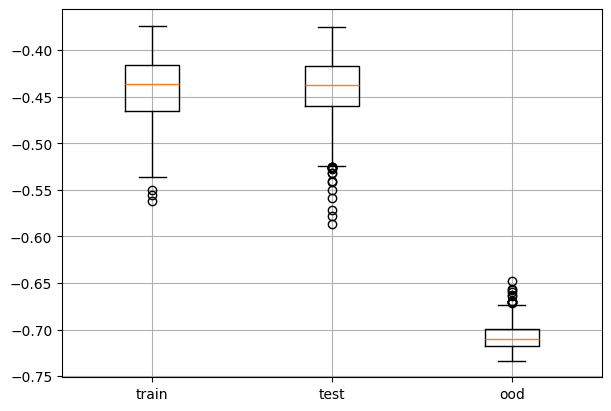

In [9]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, random_state=42)

model.fit(X_train)

train_scores = model.score_samples(X_train)
test_scores = model.score_samples(X_test)
ood_scores = model.score_samples(X_ood)


if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], tick_labels=labels)
ax1.grid()

plt.show()


In [10]:
print(model.predict(X_test))
print(model.predict(X_ood))

[ 1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1 -1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1

### IRW - Integrated Rank-Weighted depth

    based on NIPS2022 paper P.Colombo et al., Beyond Mahalanobis-Based Scores for Textual OOD Detection

fitted IRWdepth model with 1000 projections in 500 dimensions
--- 7.778813600540161 seconds ---
0.249998588
0.25121612800000004


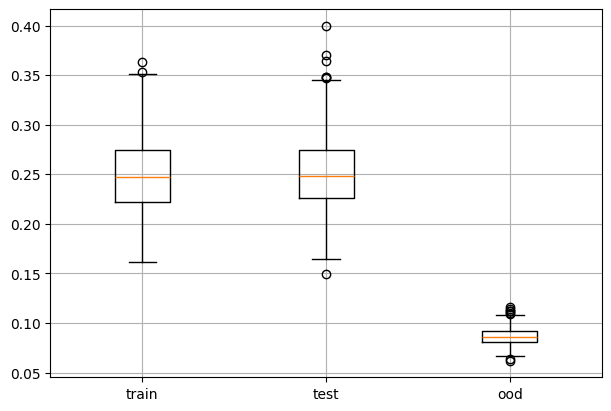

In [12]:
# IRW

from IRW_score import IRWdepth

model = IRWdepth()
nproj = 1000
model.fit(X_train, nproj)

start_time = time.time()
train_scores = [model.score(row) for row in X_train]
test_scores = [model.score(row) for row in X_test]
ood_scores = [model.score(row) for row in X_ood]
print("--- %s seconds ---" % (time.time() - start_time))


if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores)) 


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], tick_labels=labels)
ax1.grid()

plt.show()

## Problem wykrywania danych OOD w wysokich wymiarach

In [13]:
# generujemy dane MVN - dane znane (in-distribution, ID) oraz out-of-distribution (OOD) 

rng = default_rng()

d = 500
n = 2000
mi = np.full(d, 0)
cov = np.identity(d)

X_train = rng.multivariate_normal(mi, cov, n)
X_test = rng.multivariate_normal(mi, cov, n)

# OOD
delta = 10
mi2 = np.full(d, delta/math.sqrt(d))
X_ood = rng.multivariate_normal(mi2, cov, n) 


/home/hmaciej/miniconda3/lib/python3.12/site-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10168.356825029004540 > -10180.159617568444446). You may want to try with a higher value of support_fraction (current value: 0.628).
  warnings.warn(
/home/hmaciej/miniconda3/lib/python3.12/site-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10164.993073696929059 > -10170.233663966231688). You may want to try with a higher value of support_fraction (current value: 0.628).
  warnings.warn(
/home/hmaciej/miniconda3/lib/python3.12/site-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-10173.359144588112031 > -10174.010550228813372). You may want to try with a higher value of support_fracti

-659.8117293808756
-880.2013565691117
-1052.9707745244725


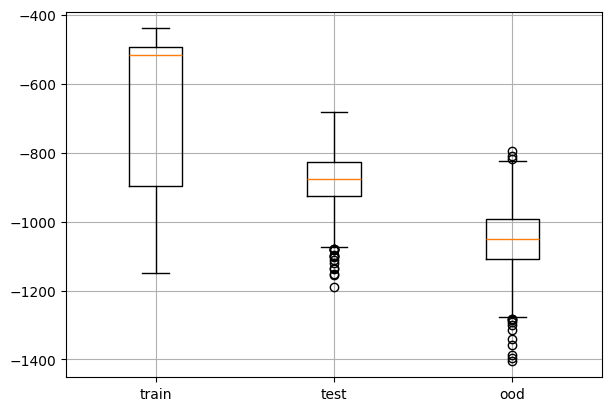

In [15]:
model = EllipticEnvelope(contamination=0.01, random_state=42)

model.fit(X_train)

train_scores = model.score_samples(X_train)
test_scores = model.score_samples(X_test)
ood_scores = model.score_samples(X_ood)


if 1:
    print(np.mean(train_scores))
    print(np.mean(test_scores))
    print(np.mean(ood_scores))


# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], tick_labels=labels)
ax1.grid()

plt.show()


-659.8117293808756
-880.2013565691117
-1052.9707745244725


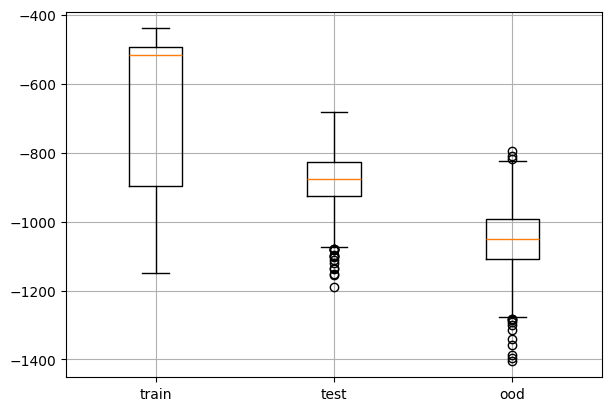

In [16]:
print(np.mean(train_scores))
print(np.mean(test_scores))
print(np.mean(ood_scores))

# boxplot
fig, ax1 = plt.subplots(figsize=(6, 4), constrained_layout=True)

labels = ['train', 'test', 'ood']
#ax1.set_ylim([40, 65])
ax1.boxplot([train_scores, test_scores, ood_scores], tick_labels=labels)
ax1.grid()

plt.show()


In [17]:
print(X_test.shape)
print(X_ood.shape)
XX = np.concatenate((X_test,X_ood), axis=0)
print(XX.shape)

yy = [0]*X_test.shape[0] + [1]*X_ood.shape[0]      # 0 - ID, 1 - OOD


(2000, 500)
(2000, 500)
(4000, 500)


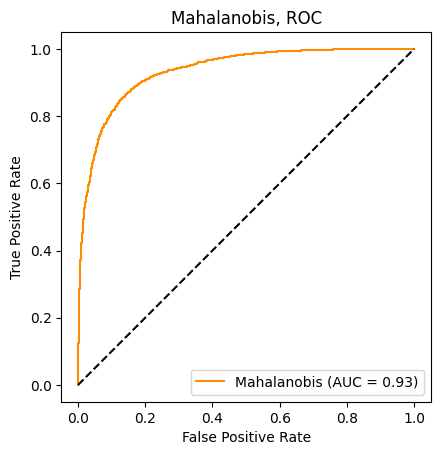

In [18]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

yy_score = -model.decision_function(XX)

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name="Mahalanobis",
    color="darkorange",
    pos_label=1
)
plt.plot([0, 1], [0, 1], "k--")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mahalanobis, ROC")
plt.legend()
plt.show()